# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [4]:
# import sys
# !{sys.executable} -m pip install pycaret
# %pip install -U rfpimp

In [5]:
"""Source: 
https://stackoverflow.com/questions/61883115/how-to-install-pycaret-python-library-in-mac-mojave"""
# !brew install cmake
# !brew install libomp
# git clone --recursive https://github.com/microsoft/LightGBM ; cd LightGBM
# mkdir build ; cd build
# cmake ..
# make -j4

# %pip install -U missingno statsmodels
# !pip3 install pycaret
# check version
# %pip install pycaret
# import pycaret
# from pycaret.utils import version
# version()

'Source: \nhttps://stackoverflow.com/questions/61883115/how-to-install-pycaret-python-library-in-mac-mojave'

In [6]:
%%time
from plugins.plugin_utils import *
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
from IPython.core.magic import (Magics, magics_class, line_magic, cell_magic)
from IPython import get_ipython
from datetime import datetime
from rfpimp import permutation_importances
%matplotlib inline

conn = prepare_connection(sqlite3.connect('starbucks.db', detect_types=sqlite3.PARSE_DECLTYPES))
@magics_class
class SqlMagic(Magics):

    @cell_magic
    def sql(self, line, cell):
        return conn.execute(cell).fetchall()

    @cell_magic
    def to_df(self, line, cell):
        return pd.read_sql(cell, conn)
    
get_ipython().register_magics(SqlMagic)    
sql = lambda x: conn.execute(x).fetchall()
to_df = lambda x: pd.read_sql(x, conn)
conv_date = lambda a: datetime.strptime(str(int(a)), '%Y%m%d').strftime('%m/%d/%Y') if not np.isnan(a) else np.NaN

# read in the json files
def load_json_file_to_table(fname):
    print(f'Loading data from {fname}...')
    fname = fname.replace('.json','')
    pd.read_json(f"data/{fname}.json", 
                 orient='records', 
                 lines=True
                ).to_sql(
                        fname,
                        conn,
                        index=False,
                        if_exists='replace')
    
load_json_file_to_table('portfolio.json')
load_json_file_to_table('profile.json')
load_json_file_to_table('transcript.json')

Loading data from portfolio.json...
Loading data from profile.json...
Loading data from transcript.json...
CPU times: user 5.76 s, sys: 780 ms, total: 6.54 s
Wall time: 6.14 s


In [7]:
%%time
def clean_transcripts():
    offers = to_df(
        """select person,
               event,
               json_extract(value, '$.offer_id') offer_id,
               json_extract(value, '$.reward')   reward,
               time
        from (
                 select person, event, replace(value, 'offer id', 'offer_id') value, time
                 from transcript
                 where event like '%offer%'
             );""")
    offers = offers.join(pd.get_dummies(offers.event, prefix='event_'),
                           how='outer').drop(columns=['event'])
    transactions = to_df("""select person, 
                               -- event, 
                               json_extract(value, '$.amount') amount, time
                            from transcript
                            where event not like '%offer%';""")

    return offers, transactions

def clean_profile():
#     profile = df.copy()
    profile = to_df('select * from profile')
    profile.age = profile.age.astype(int)
    
    #CONVERT GENDER TO CATEGORY
#     profile = pd.concat([profile, pd.get_dummies(profile.gender, prefix='gender_')]).drop(columns=['gender'])
    profile.gender = profile.gender.astype('category')
    
    #CLEAN DATE FIELD
    conv_date = lambda a: datetime.strptime(str(int(a)), '%Y%m%d').strftime('%m/%d/%Y') if not np.isnan(a) else np.NaN
    profile.became_member_on = profile.became_member_on.apply(conv_date).astype('datetime64')
    profile = profile[profile.age != 118]
    
    #BINNING AGE BRACKETS
#     mapping = [profile['age'].between(0, 22), 
#                 profile['age'].between(23, 38),
#                 profile['age'].between(39, 54),
#                 profile['age'].between(55, 73),
#                 profile['age'].between(74, 150),]
#     vals = ['gen_z', 'millenial', 'gen_x', 'ok_boomer', 'silent_gen']
#     profile['age_bracket'] = np.select(mapping, vals, 0)
    
    profile.income = profile.income.astype(int)
    return profile

def clean_portfolio():
    portfolio = to_df('select * from portfolio')
    portfolio.channels = portfolio.channels.apply(json.loads)
    portfolio.channels = portfolio.channels.apply(lambda x: sorted(x))
    'Example adapted from: https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies'
    _ = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
    portfolio[list(_)] = _
    portfolio = portfolio.drop(columns=['channels'])
#     portfolio.offer_type = portfolio.offer_type.astype('category')
    portfolio = portfolio.join(pd.get_dummies(portfolio.offer_type, prefix='offer_type_'),
                           how='outer').drop(columns=['offer_type'])

    return portfolio

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 6.91 µs


In [8]:
profile = to_df('select * from profile')
profile.age = profile.age.astype(int)

#CONVERT GENDER TO CATEGORY
#     profile = pd.concat([profile, pd.get_dummies(profile.gender, prefix='gender_')]).drop(columns=['gender'])
profile.gender = profile.gender.astype('category')

#CLEAN DATE FIELD
conv_date = lambda a: datetime.strptime(str(int(a)), '%Y%m%d').strftime('%m/%d/%Y') if not np.isnan(a) else np.NaN
profile.became_member_on = profile.became_member_on.apply(conv_date).astype('datetime64')
profile = profile[profile.age != 118]
pd.cut(profile.age, bins=[i for i in range(0, 100, 10)])

1        (50, 60]
3        (70, 80]
5        (60, 70]
8        (60, 70]
12       (50, 60]
           ...   
16995    (40, 50]
16996    (60, 70]
16997    (40, 50]
16998    (80, 90]
16999    (60, 70]
Name: age, Length: 14825, dtype: category
Categories (9, interval[int64]): [(0, 10] < (10, 20] < (20, 30] < (30, 40] ... (50, 60] < (60, 70] < (70, 80] < (80, 90]]

In [9]:
# [i for i in range(0, 100, 10)]
#     print(i)

In [10]:
%%time
offers, transactions = clean_transcripts()
portfolio = clean_portfolio()
profile = clean_profile()

CPU times: user 1.24 s, sys: 47.1 ms, total: 1.28 s
Wall time: 1.29 s


In [11]:
"""TODO:
- (Optional) - Add exploratory visualizations. Distributions, correlation matrix to check for colinearity, scatterplot etc..
- Change age bracket to bins and use get_dummies
- Remove duplicate ID columns and drop / fix NaNs
- Change reward to binary?? (look to see if Reward only goes with one type of offer)
- Input / Normalize / standarize numeric features
- Join all the datasets"""
print('Offers:\n'); display(offers.sample(5))
print('Transactions:\n'); display(transactions.sample(5))
print('Portfolio:\n'); display(portfolio.sample(5))
print('Profile:\n'); display(profile.sample(5))

Offers:



,person,offer_id,reward,time,event__offer completed,event__offer received,event__offer viewed
67394,58b8ef5107474c15ac723f0746037631,3f207df678b143eea3cee63160fa8bed,NaN,336,0,1,0
150662,e79c466771a942269ef56dcfbf50177a,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,576,1,0,0
118280,a318d28d03ec4aa4957dda94215911a2,f19421c1d4aa40978ebb69ca19b0e20d,NaN,504,0,1,0
123964,a96c28c4640949ddb38db4c7498f337f,fafdcd668e3743c1bb461111dcafc2a4,NaN,504,0,0,1
28768,fda2862641d74e19ba0a249a0e3a83f3,fafdcd668e3743c1bb461111dcafc2a4,NaN,168,0,1,0


Transactions:



,person,amount,time
11345,f1e4fd36e5a0446f83861308bddf6945,11.28,66
91566,5aa466a27dfd48e78c95f6ba3ce5fd8e,2.96,498
14175,00857b24b13f4fe0ad17b605f00357f5,0.91,84
45195,4cc297817a5c412bbb5dfa98c4afd210,14.09,270
78247,227f7c7fcd3f445691431763078d39b1,15.10,438


Portfolio:



,reward,difficulty,duration,id,email,mobile,social,web,offer_type__bogo,offer_type__discount,offer_type__informational
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1


Profile:



,gender,age,id,became_member_on,income
3034,F,58,c9e69ffd85e7421aa53b8cb7bafba100,2016-08-24,77000
11264,F,57,17688188fc61487d98f1cafdaa32c08b,2017-03-13,57000
5741,F,57,04f1f44632cd409cace939fa62b5fc7a,2016-08-26,73000
3662,F,20,c89fa9af11d74b4d8cee355d0871bd97,2016-01-11,54000
9341,M,51,3e7cfcff56634b7fb78b7eea015040f3,2017-10-21,69000


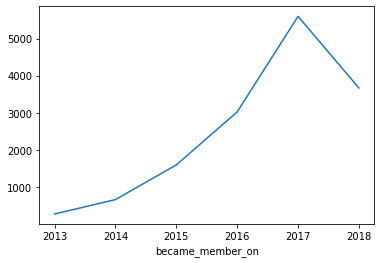

In [12]:
profile.groupby(profile.became_member_on.dt.year).count()['age'].plot()

In [13]:
# for c in list(transcript):
#     print(transcript.isnull().sum())
print('Total rows:', len(profile), len(offers), len(transactions))
sep = '\n'+'*'*60 + '\n'
# print(f'{sep}Transcript % NULLs:{sep}{transcript.isnull().sum()/len(transcript)}')
print(f'{sep}Offers % NULLs:{sep}{offers.isnull().sum()/len(offers)}')
print(f'{sep}Transactions % NULLs:{sep}{transactions.isnull().sum()/len(transactions)}')
print(f'{sep}Profile % NULLs:{sep}{profile.isnull().sum()/len(profile)}')
# print(f'{sep}Portfolio % NULLs:{sep}{portfolio.isnull().sum()/len(portfolio)}')

Total rows: 14825 167581 138953

************************************************************
Offers % NULLs:
************************************************************
person                    0.000000
offer_id                  0.000000
reward                    0.799625
time                      0.000000
event__offer completed    0.000000
event__offer received     0.000000
event__offer viewed       0.000000
dtype: float64

************************************************************
Transactions % NULLs:
************************************************************
person    0.0
amount    0.0
time      0.0
dtype: float64

************************************************************
Profile % NULLs:
************************************************************
gender              0.0
age                 0.0
id                  0.0
became_member_on    0.0
income              0.0
dtype: float64


In [14]:
transactions.to_sql('transactions_cleaned', conn, index=False, if_exists='replace') 
offers.drop(columns=['reward']).to_sql('offers_cleaned', conn, index=False, if_exists='replace') 
portfolio.to_sql('portfolio_cleaned', conn, index=False, if_exists='replace') 
profile.to_sql('profile_cleaned', conn, index=False, if_exists='replace') 


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:2653: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [15]:
%%sql
create index if not exists offers_offer_id_idx on offers(offer_id);

[]

In [16]:
joined = to_df("""select * from v_joined""")

In [17]:
print('Total:', len(joined))
print(f'{sep}Joined % NULLs:{sep}{joined.isnull().sum()/len(joined)}')
'''Dropping since theres less than 20% of rows with missing records'''
joined = joined.dropna()

Total: 167581

************************************************************
Joined % NULLs:
************************************************************
offer_person_id              0.000000
offer_id                     0.000000
profile_person_id            0.000000
portfolio_id                 0.000000
time                         0.000000
event__offer completed       0.000000
event__offer received        0.000000
event__offer viewed          0.000000
gender                       0.112041
age                          0.000000
became_member_on             0.000000
income                       0.112041
reward                       0.000000
difficulty                   0.000000
duration                     0.000000
email                        0.000000
mobile                       0.000000
social                       0.000000
web                          0.000000
offer_type__bogo             0.000000
offer_type__discount         0.000000
offer_type__informational    0.000000
transaction

In [18]:
# print("{}\n{: >30}{: >30}{: >30}\n{}".format("="*100,'|ROW|', '|COLUMN|', '|CORRELATION|',"="*100))
# for k,v in joined.corr().items():
#     for c in list(v.index):
#         if not k == c and v[c] > .5:
#             print("{: >30}{: >30}{: >30}".format(k.capitalize(), c.capitalize(), v[c]))

print(f'{sep}Correlations:{sep}')
pd.DataFrame([(*sorted([k.capitalize(), c.capitalize()]), v[c])
                     for k,v in joined.corr().items() 
                     for c in list(v.index)
        if not k == c and v[c] > .5],
            columns=['ROW','COL','CORRELATION']
            ).drop_duplicates()
# for c in joined.columns:
#     if c not in ['event__offer completed']:
#         print(c)
#         display(joined[c])
#         joined['event__offer completed'].corr(joined[c])


************************************************************
Correlations:
************************************************************



,ROW,COL,CORRELATION
0,Offer_type__bogo,Reward,0.797030
1,Difficulty,Duration,0.766816
2,Difficulty,Offer_type__discount,0.542964
4,Duration,Offer_type__discount,0.731328


In [19]:
%%time
joined.became_member_on = joined.became_member_on.apply(conv_date).astype('datetime64')
joined['days_as_customer'] = joined.became_member_on.apply(lambda x: pd.Timestamp.now() - pd.to_datetime(x)).dt.days
joined['became_member_dayofweek'] = joined.became_member_on.dt.dayofweek
joined['became_member_month'] = joined.became_member_on.dt.month
joined['became_member_year'] =  joined.became_member_on.dt.year
joined = joined.drop(columns=['became_member_on', 'time', 'reward'])

CPU times: user 5.82 s, sys: 26.5 ms, total: 5.85 s
Wall time: 5.86 s


In [20]:
joined.sample(5)

,offer_person_id,offer_id,profile_person_id,portfolio_id,event__offer completed,event__offer received,event__offer viewed,gender,age,income,...,social,web,offer_type__bogo,offer_type__discount,offer_type__informational,transaction_amount,days_as_customer,became_member_dayofweek,became_member_month,became_member_year
20309,e6fc7edd5ee748609bf5842a08af5734,fafdcd668e3743c1bb461111dcafc2a4,e6fc7edd5ee748609bf5842a08af5734,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,F,74,104000.0,...,1,1,0,1,0,27.61,1066,5,1,2018
7766,41b41a91a8c54404950837d458c3a41a,4d5c57ea9a6940dd891ad53e9dbe8da0,41b41a91a8c54404950837d458c3a41a,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,M,62,48000.0,...,1,1,1,0,0,15.05,1281,0,6,2017
44582,ba4fff69b9224b87a1916f9fd9d0c2c8,fafdcd668e3743c1bb461111dcafc2a4,ba4fff69b9224b87a1916f9fd9d0c2c8,fafdcd668e3743c1bb461111dcafc2a4,0,0,1,F,75,109000.0,...,1,1,0,1,0,22.45,1317,6,5,2017
123394,9388ac636ddd48579dc16f4faef47e73,f19421c1d4aa40978ebb69ca19b0e20d,9388ac636ddd48579dc16f4faef47e73,f19421c1d4aa40978ebb69ca19b0e20d,0,0,1,M,72,83000.0,...,1,1,1,0,0,14.44,1139,2,11,2017
81527,f67c8120151b4800b01a13f33d284ed0,2298d6c36e964ae4a3e7e9706d1fb8c2,f67c8120151b4800b01a13f33d284ed0,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0,M,40,91000.0,...,1,1,0,1,0,21.59,1491,0,11,2016


In [21]:
# key_df = joined[['person', 'offer_id','id']] 
# features = joined[[i for i in list(joined) if i not in list(key_df)]]

INCOME:


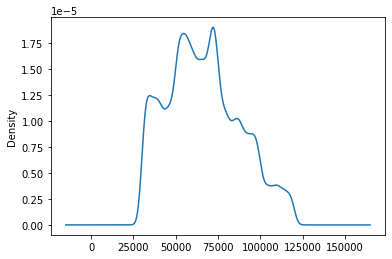

In [22]:
print('INCOME:')
joined.income.plot.kde()

AGE:


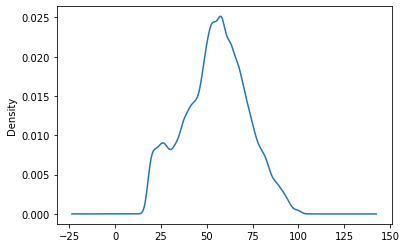

In [23]:
print('AGE:')
joined.age.plot.kde()

DAYS AS CUSTOMER:


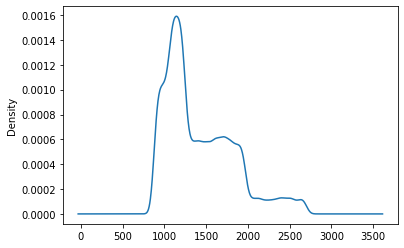

In [24]:
print('DAYS AS CUSTOMER:')
joined.days_as_customer.plot.kde()

GENDER


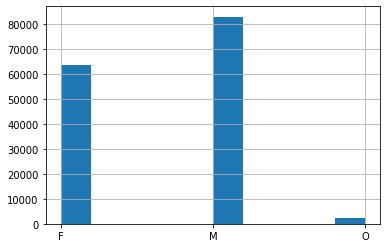

In [25]:
print('GENDER')
joined.gender.hist()

In [26]:
joined.dtypes

offer_person_id               object
offer_id                      object
profile_person_id             object
portfolio_id                  object
event__offer completed         int64
event__offer received          int64
event__offer viewed            int64
gender                        object
age                            int64
income                       float64
difficulty                     int64
duration                       int64
email                          int64
mobile                         int64
social                         int64
web                            int64
offer_type__bogo               int64
offer_type__discount           int64
offer_type__informational      int64
transaction_amount           float64
days_as_customer               int64
became_member_dayofweek        int64
became_member_month            int64
became_member_year             int64
dtype: object

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # default=(0, 1)
numerical = list(joined.select_dtypes('float'))
keys_df = joined[['offer_person_id', 'offer_id','profile_person_id', 'portfolio_id']] 
features = joined[[i for i in list(joined) if i not in list(keys_df)]]
features_log_minmax_transform = pd.DataFrame(data = features)
features_log_minmax_transform[numerical] = scaler.fit_transform(joined[numerical])
display(features_log_minmax_transform.head(n = 5))

,event__offer completed,event__offer received,event__offer viewed,gender,age,income,difficulty,duration,email,mobile,social,web,offer_type__bogo,offer_type__discount,offer_type__informational,transaction_amount,days_as_customer,became_member_dayofweek,became_member_month,became_member_year
0,0,1,0,F,75,0.777778,5,7,1,1,0,1,1,0,0,0.020674,1322,1,5,2017
2,0,1,0,M,68,0.444444,10,7,1,1,0,1,0,1,0,0.018584,970,3,4,2018
5,0,1,0,M,65,0.255556,5,5,1,1,1,1,1,0,0,0.009916,1046,4,2,2018
7,0,1,0,M,58,0.233333,0,4,1,1,0,1,0,0,1,0.002411,1136,5,11,2017
8,0,1,0,F,61,0.300000,20,10,1,0,0,1,0,1,0,0.012816,1197,0,9,2017


In [28]:
from sklearn.model_selection import train_test_split

# features = features_log_minmax_transform[[c for c in features_log_minmax_transform.columns 
#                                           if c not in ['person', 'offer_id', 'id']]]
y=features_log_minmax_transform[['event__offer completed']]
# y=features_log_minmax_transform[['transaction_amount']]
features = features_log_minmax_transform.drop(columns=['event__offer completed',
#                                                         'transaction_amount'])
                                                      ])
features.gender = features.gender.map({'M':1, 'F':2})

X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 119044 samples.
Testing set has 29761 samples.


In [29]:
features.sample(5)

,event__offer received,event__offer viewed,gender,age,income,difficulty,duration,email,mobile,social,web,offer_type__bogo,offer_type__discount,offer_type__informational,transaction_amount,days_as_customer,became_member_dayofweek,became_member_month,became_member_year
140018,1,0,2.0,76,0.577778,0,4,1,1,0,1,0,0,1,0.018875,1499,6,11,2016
75326,0,1,2.0,52,0.422222,5,7,1,1,0,1,1,0,0,0.012764,1093,6,12,2017
86701,1,0,2.0,55,0.255556,10,7,1,1,0,1,0,1,0,0.001528,1237,2,8,2017
14835,0,1,1.0,29,0.355556,5,5,1,1,1,1,1,0,0,0.023178,1863,6,11,2015
41806,0,1,2.0,68,0.133333,10,7,1,1,0,1,0,1,0,0.004542,1342,2,4,2017


In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def grid_search(model, params, X, y, X_train, y_train, X_test, y_test):
    """SOURCE: Taken from Introduction to ML project project"""
    scorer = make_scorer(f1_score)
#     g_search =  GridSearchCV(model, params, scoring=scorer)
    g_search = GridSearchCV(model, params,
                              cv=StratifiedKFold(n_splits=10, 
                                                 shuffle = True, 
                                                 random_state = 1001).split(
                                  X, y.values.ravel()), verbose=3, n_jobs=6)
    g_fit = g_search.fit(X, y.values.ravel())
    best_model = g_fit.best_estimator_
    predictions = (model.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_model.predict(X_test)
    
#     print("Unoptimized model\n------")
#     print(f"MSE: {mean_squared_error(y_test, predictions)}")
#     print(f"MAE: {mean_absolute_error(y_test, predictions)}")
#     print(f"R2: {r2_score(y_test, predictions)}")
#     print("\nOptimized Model\n------")
#     print(f"MSE: {mean_squared_error(y_test, best_predictions)}")
#     print(f"MAE{mean_absolute_error(y_test, best_predictions)}")
#     print(f"R2: {r2_score(y_test, best_predictions)}")
#     return {
#         'best_model': best_model,
#         'unoptimized_mse_score': mean_squared_error(y_test, predictions),
#         'unoptimized_mae_score': mean_absolute_error(y_test, predictions),
#         'unoptimized_r2_score': r2_score(y_test, predictions),
#         'optimized_mse_score': mean_squared_error(y_test, best_predictions),
#         'optimized_mae_score': mean_absolute_error(y_test, best_predictions),
#         'optimized_r2_score': r2_score(y_test, best_predictions),
#     }
    print("Unoptimized model\n------")
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
    print("\nOptimized Model\n------")
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))    
    return {
        'best_clf': best_model,
        'unoptimized_accuracy_score': accuracy_score(y_test, predictions),
        'unoptimized_beta_score': fbeta_score(y_test, predictions, beta = 0.5),
        'optimized_accuracy_score': accuracy_score(y_test, best_predictions),
        'optimized_beta_score':fbeta_score(y_test, best_predictions, beta = 0.5),
    }


In [33]:
%%time
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, fbeta_score, accuracy_score

xgb_params = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_search_results = grid_search(xgb.XGBClassifier(objective = 'reg:squarederror'), #'reg:linear'),
                          xgb_params, features, y, 
                          X_train, y_train,
                          X_test, y_test)

# '''Example parameters taken from: https://www.kaggle.com/jayatou/xgbregressor-with-gridsearchcv'''
# xgb_params = {'nthread':[4], 
#               'objective':['reg:linear'],
#               'learning_rate': [.03, 0.05, .07], 
#               'max_depth': [5, 6, 7],
#               'min_child_weight': [4],
#               'silent': [1],
#               'subsample': [0.7],
#               'colsample_bytree': [0.7],
#               'n_estimators': [500]}

# xgbr = xgb.XGBRegressor(objective="reg:linear", random_state=42)
# grid_search_results = grid_search(xgbr,
#                           xgb_params, features, y, 
#                           X_train, y_train,
#                           X_test, y_test)


Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   23.9s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  8.0min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed: 14.7min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed: 24.1min
[Parallel(n_jobs=6)]: Done 960 out of 960 | elapsed: 29.8min finished


[13:20:05] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:20:06] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:20:06] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[13:20:07] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
Unoptimized model
------
Accuracy score on testing data: 1.0000
F-score on testing data: 1.0000

Optimized Model
------
Final accuracy score on the testing data: 1.0000
Final F-score on the testing data: 1.0000
CPU times: user 27.7 s, sys: 851 ms, total: 28.5 s
Wall time: 29min 48s


In [34]:
grid_search_results

{'best_clf': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.1, max_delta_step=0, max_depth=2,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=60, n_jobs=0, num_parallel_tree=1,
               objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
               scale_pos_weight=1, subsample=1, tree_method='exact',
               validate_parameters=1, verbosity=None),
 'unoptimized_accuracy_score': 1.0,
 'unoptimized_beta_score': 1.0,
 'optimized_accuracy_score': 1.0,
 'optimized_beta_score': 1.0}

In [35]:
import pickle
with open('grid_search_results.pkl', 'wb') as f:
    pickle.dump(grid_search_results, f, protocol=pickle.HIGHEST_PROTOCOL)


In [36]:
import pickle
with open('grid_search_results.pkl', 'rb') as f:
    grid_search_results = pickle.load(f)


[13:28:37] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [37]:
# x = grid_search_results['best_clf']
grid_search_results['best_clf']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=0, num_parallel_tree=1,
              objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [81]:
# x = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
#               importance_type='gain', interaction_constraints='',
#               learning_rate=0.1, max_delta_step=0, max_depth=2,
#               min_child_weight=1, missing=np.nan, monotone_constraints='()',
#               n_estimators=60, n_jobs=0, num_parallel_tree=1,
#               objective='binary:logistic', random_state=0, reg_alpha=0,
#               reg_lambda=1, scale_pos_weight=1, subsample=1,
#               tree_method='exact', validate_parameters=1, verbosity=None)
x = grid_search_results['best_clf']

In [82]:
X_train_temp = X_train[[i for i in list(X_train) 
                       if i not in 
                        [
                       'event__offer received',
                        'event__offer viewed',
                        'days_as_customer',
                        'became_member_month',
                        'became_member_year',
                        ]
                       ]]
X_test_temp = X_test[[i for i in list(X_test) 
                       if i not in [
                       'event__offer received',
                        'event__offer viewed',
                        'days_as_customer',
                        'became_member_month',
                        'became_member_year',
                       ]
                     ]]
"""TODO:
- Change to XGB to Regression model
- Figure out which vars to remove
"""

'TODO:\n- Change to XGB to Regression model\n- Figure out which vars to remove\n'

In [83]:
x.fit(X_train_temp, y_train)
predictions = x.predict(X_test_temp)
print("\nOptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))

[14:02:10] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:02:11] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.

Optimized model
------
Accuracy score on testing data: 0.7823
F-score on testing data: 0.0000


In [84]:
# x.predict(X_test)
xt = X_test_temp.copy()
xt['predicted'] = x.predict(X_test_temp) 
xt['actual'] = x.predict(X_test_temp)
xt[xt.predicted != xt.actual]

,gender,age,income,difficulty,duration,email,mobile,social,web,offer_type__bogo,offer_type__discount,offer_type__informational,transaction_amount,became_member_dayofweek,predicted,actual


In [85]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [116]:
vif = calc_vif(features.dropna())
vif = vif[vif.VIF > 10]
vif.VIF = vif.VIF.replace([np.inf, -np.inf], np.nan)
vif = vif.dropna()
display(vif)
print(f'Dropping variables with high VIF values: {vif.variables.tolist()}')
features = features[[c for c in features.columns if c not in vif.variables.tolist()]]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF


Dropping variables with high VIF values: []


In [115]:
# x.feature_importances_
features.dtypes

event__offer received          int64
event__offer viewed            int64
gender                       float64
age                            int64
income                       float64
difficulty                     int64
duration                       int64
email                          int64
mobile                         int64
social                         int64
web                            int64
offer_type__bogo               int64
offer_type__discount           int64
offer_type__informational      int64
transaction_amount           float64
became_member_dayofweek        int64
dtype: object

In [95]:
'''Adapted from:
https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
'''
r2 = lambda rf, X_train, y_train : r2_score(y_train.values.ravel(), rf.predict(X_train))
permutation_importances(x, X_train_temp, y_train, r2)

[14:52:31] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:52:31] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,Importance
Feature,
transaction_amount,0.009584
income,0.001198
duration,0.001198
gender,0.000000
age,0.000000
difficulty,0.000000
email,0.000000
mobile,0.000000
social,0.000000
